# Autoregressive Moving Average (ARMA)

In [1]:
import pandas as pd
import numpy as np

# Set to see all columns
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
csv_file = 'data/01_bronze/2018.csv'
df = pd.read_csv(csv_file)
df.shape

(7213446, 28)

# EDA

In [3]:
# Visualizamos informacion de la columna DEP_DELAY
df.DEP_DELAY.info()

# Contamos la cantidad de valores nulos
df.DEP_DELAY.isna().sum()

<class 'pandas.core.series.Series'>
RangeIndex: 7213446 entries, 0 to 7213445
Series name: DEP_DELAY
Non-Null Count    Dtype  
--------------    -----  
7096212 non-null  float64
dtypes: float64(1)
memory usage: 55.0 MB


117234

In [4]:
# Nos quedamos con los DEP_DELAY que tienen datos
df_dep_delay = df[df['DEP_DELAY'].notna()]
df_dep_delay.shape

(7096212, 28)

In [5]:
# Calculamos promedio de demora de partida por origen y dia (opcion 2)
df_mean_dep_delay = df_dep_delay.groupby(["ORIGIN", "FL_DATE"])\
    .agg(MEAN_DEP_DELAY=('DEP_DELAY', 'mean'))\
    .reset_index()

df_mean_dep_delay

,ORIGIN,FL_DATE,MEAN_DEP_DELAY
0,ABE,2018-01-01,7.833333
1,ABE,2018-01-02,77.375000
2,ABE,2018-01-03,51.333333
3,ABE,2018-01-04,30.125000
4,ABE,2018-01-05,17.375000
...,...,...,...
121460,YUM,2018-12-27,4.250000
121461,YUM,2018-12-28,2.250000
121462,YUM,2018-12-29,3.500000
121463,YUM,2018-12-30,3.750000


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# runtime configuration (rc) containing the default styles for every plot element
plt.rcParams['figure.figsize']=(16,6) 

## Analizamos el ORIGIN = JFK

In [7]:
# Nos quedamos con el aeropuerto de New York
data = df_mean_dep_delay[df_mean_dep_delay['ORIGIN']=='JFK']
data.drop(['ORIGIN'], axis=1, inplace=True)
data.set_index('FL_DATE', inplace=True)
data.index = pd.to_datetime(data.index)
data = data.asfreq(pd.infer_freq(data.index))
data

,MEAN_DEP_DELAY
FL_DATE,
2018-01-01,18.311475
2018-01-02,18.047478
2018-01-03,10.893548
2018-01-04,71.066667
2018-01-05,154.356164
...,...
2018-12-27,4.470430
2018-12-28,29.405914
2018-12-29,13.348571


<AxesSubplot:xlabel='FL_DATE'>

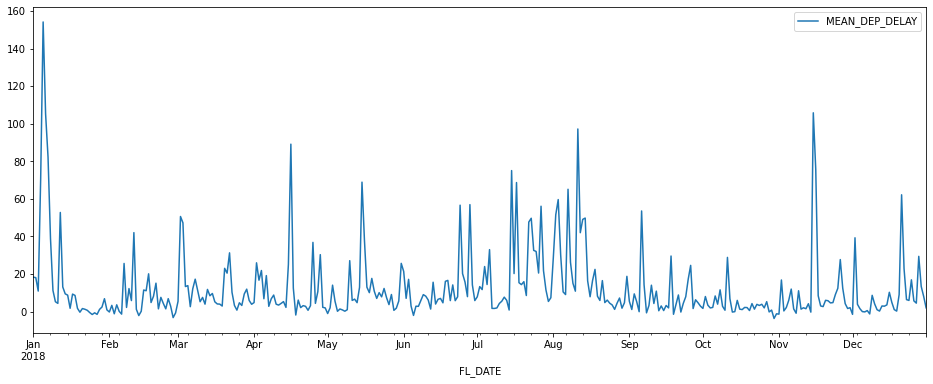

In [8]:
data.plot()

In [9]:
from statsmodels.tsa.stattools import adfuller

# Función para testear si un dataset es estacionario
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

In [10]:
#  Augmented Dickey-Fuller (ADF) test. Corroboramos que la serie es estacionaria
test_stationarity(data, 'MEAN_DEP_DELAY') 

'Stationary'

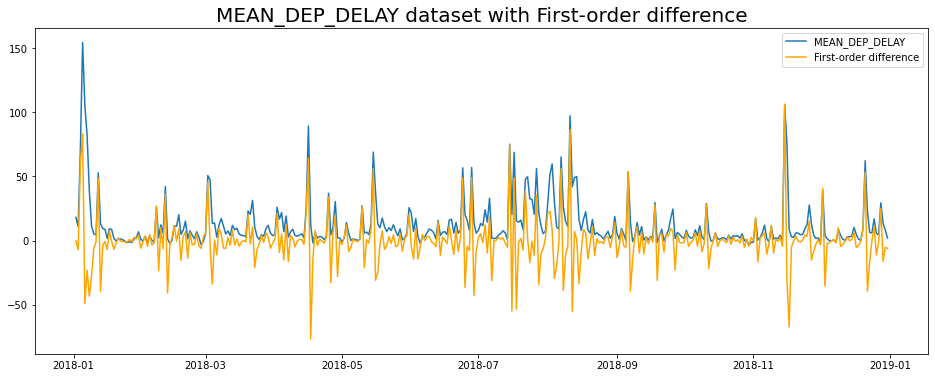

In [11]:
# Podemos comprobar también graficamente que la serie es estacionaria
# La curva actual y la de la 1er diferencia se acoplan muy bien!

# First-order difference
data['MEAN_DEP_DELAY_Diff'] = data['MEAN_DEP_DELAY'].diff(periods=1)
data = data.dropna()

# Plot
plt.title('MEAN_DEP_DELAY dataset with First-order difference', size=20)
plt.plot(data['MEAN_DEP_DELAY'], label='MEAN_DEP_DELAY')
plt.plot(data['MEAN_DEP_DELAY_Diff'], label='First-order difference', color='orange')
plt.legend();

In [12]:
from statsmodels.tsa.stattools import acf, pacf

# Calculate autocorrelation
acf_values = acf(data['MEAN_DEP_DELAY_Diff'])
np.round(acf_values, 2)

array([ 1.  , -0.28, -0.12, -0.1 ,  0.01, -0.03,  0.  ,  0.06, -0.04,
       -0.03,  0.03,  0.01,  0.06, -0.04, -0.06,  0.01, -0.05,  0.11,
       -0.08,  0.07, -0.03,  0.05, -0.12,  0.06, -0.02,  0.02,  0.01,
        0.  , -0.05,  0.03,  0.06, -0.06, -0.  , -0.04, -0.  ,  0.02,
        0.1 , -0.07, -0.01, -0.01,  0.03])

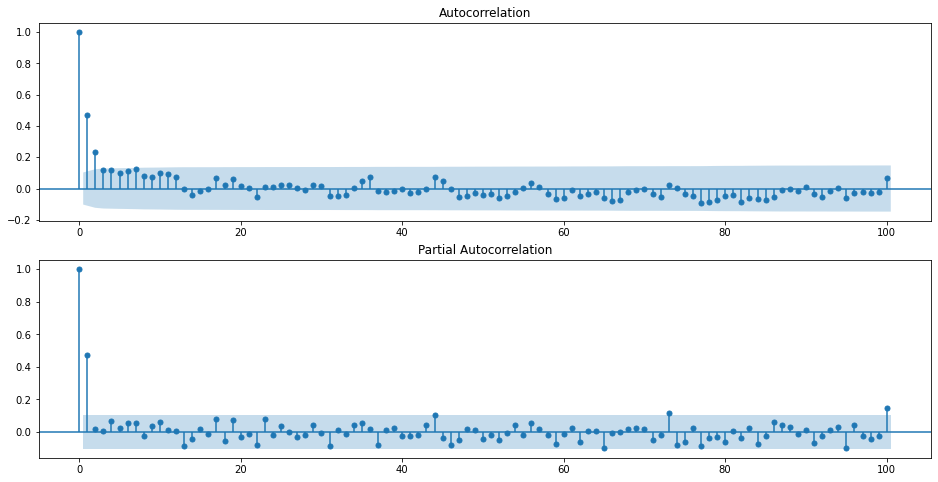

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm


# De las gráficas de autocorrelación se observa que no hay datos fuera de la zana sombreada
# Implica que no hay autocorrelacion??
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=100, ax=ax2)

In [15]:
# Como la serie es estacionaria aplicamos el modelo ARMA(p, q) = ARIMA (p, n=0, q)

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as tsa
from joblib import Parallel, delayed

max_p, max_q = 5, 5

def get_order_sets(n, n_per_set) -> list:
    n_sets = [i for i in range(n)]
    order_sets = [
        n_sets[i:i + n_per_set]
        for i in range(0, n, n_per_set)
    ]
    return order_sets


def find_aic_for_model(data, p, n, q, model, model_name):
    try:
        msg = f"Fitting {model_name} with order p, q = {p, q}\n"
        print(msg)
        if p == 0 and q == 1:
            # since p=0 and q=1 is already
            # calculated
            return None, (p, q)
        ts_results = model(data, order=(p, 0, q)).fit(disp=False)
        curr_aic = ts_results.aic
        return curr_aic, (p, q)
    except Exception as e:
        f"""Exception occurred continuing {e}"""
        return None, (p, q)

    
def find_best_order_for_model(data, model, model_name):
    p_ar, q_ma = max_p, max_q
    final_results = []
    ts_results = model(data, order=(0, 0, 1)).fit()
    min_aic = ts_results.aic
    final_results.append((min_aic, (0, 0, 1)))
    # example if q_ma is 6
    # order_sets would be [[0, 1, 2, 3, 4], [5]]
    order_sets = get_order_sets(q_ma, 5)
    for p in range(0, p_ar):
        for order_set in order_sets:
            # fit the model and find the aic
            results = Parallel(n_jobs=len(order_set), prefer='threads')(
                delayed(find_aic_for_model)(data, p, 0, q, model, model_name)
                for q in order_set
            )
            final_results.extend(results)
    results_df = pd.DataFrame(
        final_results,
        columns=['aic', 'order']
    )
    min_df = results_df[
        results_df['aic'] == results_df['aic'].min()
    ]
    min_aic = min_df['aic'].iloc[0]
    min_order = min_df['order'].iloc[0]
    return min_aic, min_order, results_df


In [16]:
# Hallamos el par (p, q) que minimiza el AIC (Akaike information criterion)
# El mínimo AIC señala el mejor modelo para el dataset

# Quitamos la columna MEAN_DEP_DELAY_Diff
#data.drop(['MEAN_DEP_DELAY_Diff'], axis=1, inplace=True)

min_aic, min_order, results_df = find_best_order_for_model(
    data, ARIMA, "ARMA"
)

print(min_aic, min_order) # Output 3117.5515312297694 (0, 0, 1) -> (p=0, 0, q=1)

Fitting ARMA with order p, q = (0, 0)

Fitting ARMA with order p, q = (0, 1)

Fitting ARMA with order p, q = (0, 2)

Fitting ARMA with order p, q = (0, 3)

Fitting ARMA with order p, q = (0, 4)

Fitting ARMA with order p, q = (1, 0)

Fitting ARMA with order p, q = (1, 1)

Fitting ARMA with order p, q = (1, 2)

Fitting ARMA with order p, q = (1, 3)

Fitting ARMA with order p, q = (1, 4)

Fitting ARMA with order p, q = (2, 0)

Fitting ARMA with order p, q = (2, 1)

Fitting ARMA with order p, q = (2, 2)

Fitting ARMA with order p, q = (2, 3)

Fitting ARMA with order p, q = (2, 4)

Fitting ARMA with order p, q = (3, 0)

Fitting ARMA with order p, q = (3, 1)

Fitting ARMA with order p, q = (3, 2)

Fitting ARMA with order p, q = (3, 3)

Fitting ARMA with order p, q = (3, 4)

Fitting ARMA with order p, q = (4, 0)

Fitting ARMA with order p, q = (4, 1)

Fitting ARMA with order p, q = (4, 2)

Fitting ARMA with order p, q = (4, 3)

Fitting ARMA with order p, q = (4, 4)

3117.5515312297694 (0, 0,

In [17]:
# Función para buscar anomalías
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

In [18]:
arma = tsa.ARIMA(data, order=min_order)
arma_fit = arma.fit(disp=0)
squared_errors = arma_fit.resid ** 2
predictions, threshold = find_anomalies(squared_errors)

In [19]:
# Mostramos el threshold que clasifica las anomalías
print(f"threshold: {threshold}")

threshold: 1415.9794691997001


In [20]:
# Vemos las frecuencias. El valor data['predictions']==1 corresponde a una anomalía. El valor 0 a un valor normal.
data['predictions'] = predictions
data['predictions'].value_counts()

0    346
1     19
Name: predictions, dtype: int64

In [42]:
# Anomalías encontradas
data[data['predictions']==1]

,MEAN_DEP_DELAY,predictions
FL_DATE,,
2018-01-04,71.066667,1
2018-01-05,154.356164,1
2018-01-06,105.391837,1
2018-01-07,82.267742,1
2018-01-12,52.802419,1
2018-03-02,50.654255,1
2018-04-16,89.207273,1
2018-05-15,68.961290,1
2018-06-24,56.687671,1


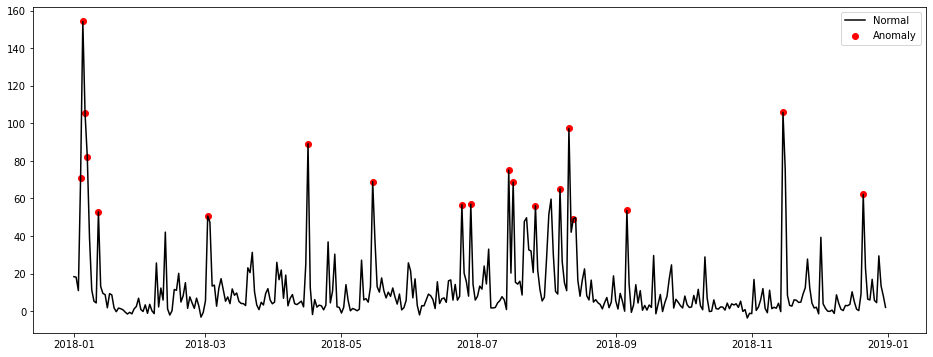

In [23]:
# visualization
fig, ax = plt.subplots(figsize=(16,6))

a = data.loc[data['predictions'] == 1, ['MEAN_DEP_DELAY']] #anomaly

ax.plot(data.index, data['MEAN_DEP_DELAY'], color='black', label = 'Normal')
ax.scatter(a.index,a['MEAN_DEP_DELAY'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

# Algunas pruebas adicionales

In [110]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as tsa

data2 = data['MEAN_DEP_DELAY'].squeeze()

order=(2, 0, 0)
arma_mod20 = tsa.ARIMA(data2, order=order).fit(disp=0)
curr_aic = arma_mod20.aic
print(f"AIC: {curr_aic}, order: {order}")

AIC: 3101.4860527382975, order: (2, 0, 0)


In [111]:
print(arma_mod20.params)

const                   12.403745
ar.L1.MEAN_DEP_DELAY     0.460848
ar.L2.MEAN_DEP_DELAY     0.016148
dtype: float64


In [112]:
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

3101.4860527382975 3117.0856421526273 3107.685532362797


In [113]:
order=(3, 0, 0)
arma_mod30 = tsa.ARIMA(data2, order=order).fit(disp=0)
curr_aic = arma_mod30.aic
print(f"AIC: {curr_aic}, order: {order}")

AIC: 3103.4721518267356, order: (3, 0, 0)


In [114]:
print(arma_mod30.params)

const                   12.403512
ar.L1.MEAN_DEP_DELAY     0.460745
ar.L2.MEAN_DEP_DELAY     0.013301
ar.L3.MEAN_DEP_DELAY     0.006150
dtype: float64


In [115]:
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

3103.4721518267356 3122.971638594648 3111.22150135736
